In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

originaldataDf = pd.read_csv('../data/METABRIC_RNA_Mutation.csv')
print(len(originaldataDf))
dataDf = originaldataDf.dropna()
print("after dropNA", len(dataDf))
# dataDf.head(n=3)

1904
after dropNA 1092


In [12]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(dataDf)

for colName in categorical_columns:
    dataDf[colName] = dataDf[colName].apply(str)

# x_train, x_test, y_train, y_test = train_test_split(X_scaled, survivalMonthLt, test_size=0.2, random_state=2)
categDf = dataDf[categorical_columns]
# encoder = OrdinalEncoder().set_output(transform="pandas")
encoder = OrdinalEncoder()
cate_encodedDf = encoder.fit_transform(categDf)
dataDf[categorical_columns] = cate_encodedDf
# dataDf.tail(n=3)

In [13]:
#drop sparse columns if 0 is above 95%
# print(len(list(dataDf.columns)))
dropLt = []
for ii, nCol in enumerate(list(dataDf.columns)):
#     if ii == 100: break
    rowList = list(dataDf[nCol])
    zeroPercent = round(rowList.count(0)/len(rowList)*100, 0)
#     if zeroPercent >= 95:
    if zeroPercent >= 99:
        dropLt.append(nCol)
dataDf = dataDf.drop(columns=dropLt)
# print(len(dataDf.columns))
# dataDf.head(n=3)

In [14]:
# print(dataDf.columns[0:40])
depenVarLt = ['patient_id', 'overall_survival_months', 'death_from_cancer', 'overall_survival']
dataNoDepenVarDf = dataDf.drop(columns=depenVarLt)
dataNoDepenVarNp = dataNoDepenVarDf.to_numpy()

scaler = preprocessing.StandardScaler().fit(dataNoDepenVarNp)
# scaler.mean_
X_scaled = scaler.transform(dataNoDepenVarNp)

overall_survival_months [0.0, 1.43, 2.5, 2.0, 4.43, 5.5, 3.5, 5.07, 8.07, 9.07]
death from cancer: {nan, 'Died of Other Causes', 'Died of Disease', 'Living'}
overal survival: {0, 1}


,overall_survival_months,death_from_cancer,overall_survival
overall_survival_months,1.000000,0.494776,0.423557
death_from_cancer,0.494776,1.000000,0.909949
overall_survival,0.423557,0.909949,1.000000


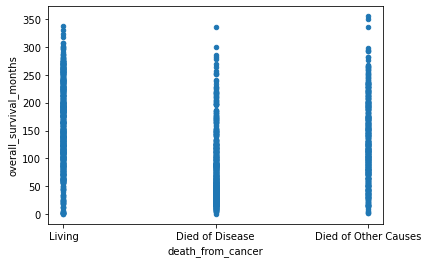

In [15]:
dependOriThreeVarDf = originaldataDf[['overall_survival_months', 'death_from_cancer', 'overall_survival']]
survivalMonthSet = set(list(dependOriThreeVarDf['overall_survival_months']))
deathFromCancerOriSet = set(list(dependOriThreeVarDf['death_from_cancer']))
overAllSurvivalOriSet = set(list(dependOriThreeVarDf['overall_survival']))
print("overall_survival_months",  [round(x, 2) for x in survivalMonthSet][0:10])
print("death from cancer:", deathFromCancerOriSet)
print("overal survival:", overAllSurvivalOriSet)
dependThreeVarDf = dataDf[['overall_survival_months', 'death_from_cancer', 'overall_survival']]

dependOriNoNa3VarDf = dependOriThreeVarDf.dropna()
ax1 = dependOriNoNa3VarDf.plot.scatter(x = 'death_from_cancer', y = 'overall_survival_months')
dependThreeVarDf.corr()

801 622 480


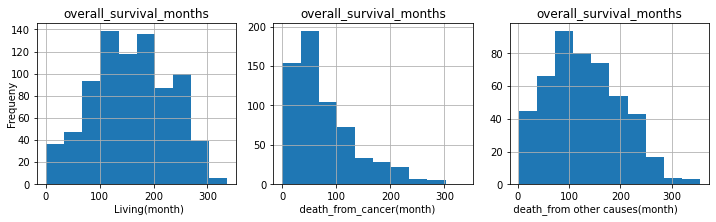

In [16]:
survivalMonthLivingDf = dependOriNoNa3VarDf[dependOriNoNa3VarDf['death_from_cancer'] == 'Living']
survivalMonthDeadDiseaseDf = dependOriNoNa3VarDf[dependOriNoNa3VarDf['death_from_cancer'] == 'Died of Disease']
survivalMonthDeadOtherDf = dependOriNoNa3VarDf[dependOriNoNa3VarDf['death_from_cancer'] == 'Died of Other Causes']
print(len(survivalMonthLivingDf), len(survivalMonthDeadDiseaseDf), len(survivalMonthDeadOtherDf))

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1, 3, 1)
survivalMonthLivingDf.hist(column='overall_survival_months', ax = ax1)
ax2 = fig.add_subplot(1, 3, 2)
survivalMonthDeadDiseaseDf.hist(column='overall_survival_months', ax = ax2)
ax3 = fig.add_subplot(1, 3, 3)
survivalMonthDeadOtherDf.hist(column='overall_survival_months', ax = ax3)
fig.text(0.55, 0.001, 'Living(month)                                     death_from_cancer(month)                         death_from other causes(month)', ha='center')
fig.text(0.01, 0.5, 'Frequeny', va='center', rotation='vertical')
fig.tight_layout()

In [17]:
survivalMonthLt =  list(dataDf['overall_survival_months'])
x_train, x_test, y_train, y_test = train_test_split(X_scaled, survivalMonthLt, test_size=0.2, random_state=2)

poly = PolynomialFeatures(degree=2, include_bias=True)
x_train_trans = poly.fit_transform(x_train)
x_test_trans = poly.transform(x_test)
#include bias parameter
lr = LinearRegression()
lr.fit(x_train_trans, y_train)
y_pred = lr.predict(x_test_trans)
print("The r square is", r2_score(y_test, y_pred))

The r square is -0.011340337005591561


[Text(0.5, 0, 'data point'),
 Text(0, 0.5, 'survival month'),
 Text(0.5, 1.0, 'polynominal regression: Survival Month VS all variables\n The r-square is -0.01')]

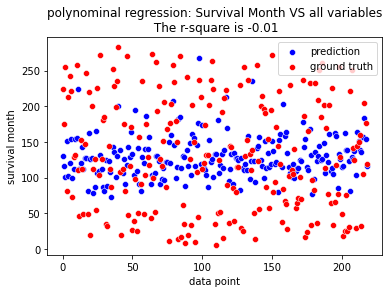

In [18]:
ax = sns.scatterplot(x=[x for x in range(len(y_pred))] , y=y_pred, color = "blue", label="prediction")
ax = sns.scatterplot(x=[x for x in range(len(y_pred))] , y=y_test, color = "red", label="ground truth")
titleStr = "polynominal regression: Survival Month VS all variables\n The r-square is " + str(round(r2_score(y_test, y_pred), 2))
ax.set(xlabel='data point', ylabel='survival month', title= titleStr)

In [19]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

deathFromCancerLt= list(dataDf['death_from_cancer'])
classifierLt = [RandomForestClassifier(), DecisionTreeClassifier(),AdaBoostClassifier(), LogisticRegression(), GaussianNB()]
xLt = ["RandomForest", "Decision Tree", "AdaBoost", "Logistic Regression", "GaussianNB"]
accDic, rocDic = {}, {}
for ii, cClf in enumerate(classifierLt):
    # if ii == 1: break
    scoresAcc = cross_val_score(cClf, X_scaled, deathFromCancerLt, cv=5, scoring='accuracy')
    myscore = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)
    crossValROC = cross_validate(cClf, X_scaled, deathFromCancerLt, cv=5, scoring = myscore)
    accDic[xLt[ii]] = scoresAcc
    rocDic[xLt[ii]] = crossValROC['test_score']
print('----------------------------------------------------')

----------------------------------------------------


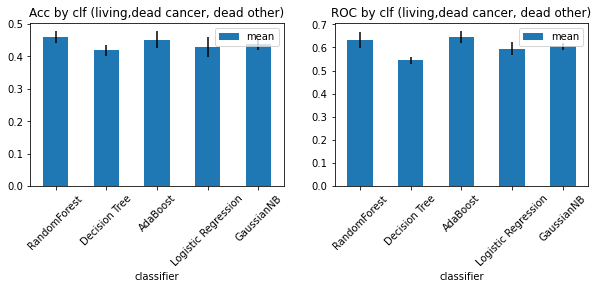

In [20]:
accDf, rocDf = pd.DataFrame(data=accDic), pd.DataFrame(data=rocDic)
accMeanSteDf = {'classifier':list(accDf.columns), 'mean':list(accDf.mean()), 'standard err': list(accDf.sem())}
accMeanSteDf = pd.DataFrame(data=accMeanSteDf)

rocMeanSteDf = {'classifier':list(rocDf.columns), 'mean':list(rocDf.mean()), 'standard err': list(rocDf.sem())}
rocMeanSteDf = pd.DataFrame(data=rocMeanSteDf)

# print(rocMeanSteDf)
fig = plt.figure(figsize=(10,3))
# plt.title("aaaaaaaaaaaaaaa", pad="9.0")
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax = accMeanSteDf.plot.bar(x='classifier', y = 'mean', yerr='standard err', rot=45, title = 'Acc by clf (living,dead cancer, dead other)', ax = ax1)
ax = rocMeanSteDf.plot.bar(x='classifier', y = 'mean', yerr='standard err', rot=45, title = 'ROC by clf (living,dead cancer, dead other)', ax = ax2)

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

deathFromCancerLt= list(dataDf['death_from_cancer'])
y_pred = cross_val_predict(AdaBoostClassifier(), X_scaled, deathFromCancerLt, cv=5)
conf_mat = confusion_matrix(deathFromCancerLt, y_pred)
mux = pd.MultiIndex.from_arrays([['ground truth', 'ground truth', 'ground truth'], 
                                ['Living', 'Died of Disease', 'Died of Other Causes']])
conf_mat = np.array(conf_mat)
confDic = {'Living':conf_mat[:, 0], 'Died of Disease':conf_mat[:, 1], 'Died of Other Causes':conf_mat[:, 2],
   'sum':[sum( conf_mat[0,:]), sum( conf_mat[1,:] ), sum( conf_mat[2,:] )]}
confDf = pd.DataFrame(confDic, mux)
mergeColLt = [('Prediction (Ada Boost)', 'Living'), ('Prediction (Ada Boost)', 'Died of Disease'), 
              ('Prediction (Ada Boost)', 'Died of Other Causes'), ('Prediction (Ada Boost)', 'sum')]
confDf.columns=pd.MultiIndex.from_tuples(mergeColLt)
confDf

Prediction (Ada Boost)                  \
                                                  Living Died of Disease   
ground truth Living                                  181              63   
             Died of Disease                          82              63   
             Died of Other Causes                    166              69   

                                                             
                                  Died of Other Causes  sum  
ground truth Living                                126  370  
             Died of Disease                        93  238  
             Died of Other Causes                  249  484

In [22]:
overallSurvList = list(dataDf['overall_survival'])
classifierLt = [RandomForestClassifier(), DecisionTreeClassifier(),AdaBoostClassifier(), LogisticRegression(), GaussianNB()]
xLt = ["RandomForest", "Decision Tree", "AdaBoost", "Logistic Regression", "GaussianNB"]
accDic, rocDic = {}, {}
for ii, cClf in enumerate(classifierLt):
#     if ii == 1: break
    # print(ii, xLt[ii])
    scoresAcc = cross_val_score(cClf, X_scaled, overallSurvList, cv=5, scoring='accuracy')
    scoresRoc = cross_val_score(cClf, X_scaled, overallSurvList, cv=5, scoring="roc_auc")
    accDic[xLt[ii]], rocDic[xLt[ii]] = scoresAcc, scoresRoc
    # print(scoresAcc, scoresRoc)
# print(accDic)
# print(rocDic)
print("--------------------------------")

--------------------------------


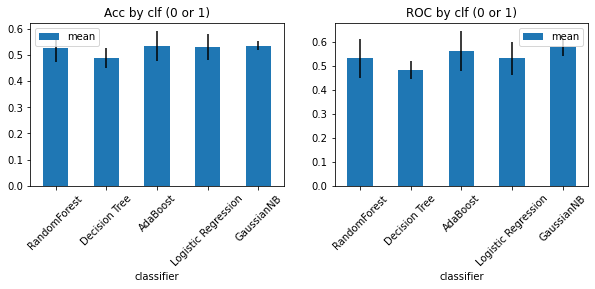

In [23]:
accDf, rocDf = pd.DataFrame(data=accDic), pd.DataFrame(data=rocDic)
accMeanSteDf = {'classifier':list(accDf.columns), 'mean':list(accDf.mean()), 'standard err': list(accDf.sem())}
accMeanSteDf = pd.DataFrame(data=accMeanSteDf)

rocMeanSteDf = {'classifier':list(rocDf.columns), 'mean':list(rocDf.mean()), 'standard err': list(rocDf.sem())}
rocMeanSteDf = pd.DataFrame(data=rocMeanSteDf)

# print(rocMeanSteDf)
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax = accMeanSteDf.plot.bar(x='classifier', y = 'mean', yerr='standard err', rot=45, title = 'Acc by clf (0 or 1)', ax = ax1)
ax = rocMeanSteDf.plot.bar(x='classifier', y = 'mean', yerr='standard err', rot=45, title = 'ROC by clf (0 or 1)', ax = ax2)

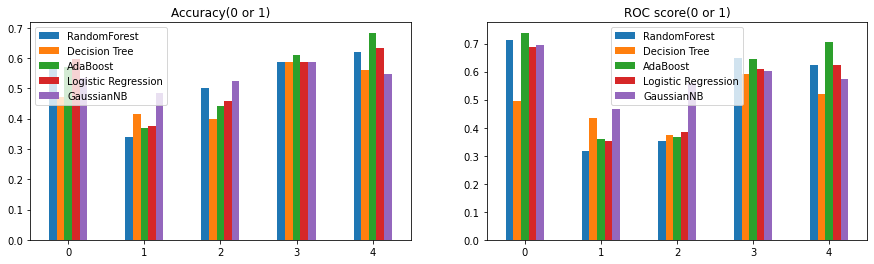

In [24]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
accBar = accDf.plot.bar(rot=0, title='Accuracy(0 or 1)', ax = ax1)
RocBar = rocDf.plot.bar(rot=0, title='ROC score(0 or 1)', ax = ax2)

In [25]:
dropLt = ['patient_id', 'overall_survival_months', 'overall_survival']
byColAnalDf = originaldataDf.drop(columns=dropLt)
categorical_columns = categorical_columns_selector(byColAnalDf)

for colName in categorical_columns:
    byColAnalDf[colName] = byColAnalDf[colName].apply(str)

categDf = byColAnalDf[categorical_columns]
# encoder = OrdinalEncoder().set_output(transform="pandas")
encoder = OrdinalEncoder()
cate_encodedDf = encoder.fit_transform(categDf)
byColAnalDf[categorical_columns] = cate_encodedDf

# colLt = list(byColAnalDf.columns)
# colLt.remove('death_from_cancer')
# colNameScoreLt = []
# for ii, cColName in enumerate(colLt):
#     # if ii == 10: break
#     if ii % 50 == 0: print(ii)
#     twoDf = byColAnalDf[['death_from_cancer', cColName]]
#     twoDf = twoDf.dropna()
#     yLt = list(twoDf['death_from_cancer'])
#     X_Lt = list(twoDf[cColName])
#     X_Lt = [[x] for x in X_Lt]
#     scoresAcc = cross_val_score(AdaBoostClassifier(), X_Lt, yLt, cv=5, scoring='accuracy')
#     scoresAccMean = sum(scoresAcc)/len(scoresAcc)
#     colNameScoreLt.append([cColName, round(scoresAccMean, 3)])

# def sortRuleFun(iLt):
#     return iLt[1]
    
# colNameScoreLt.sort(key=sortRuleFun, reverse=True)
# print(colNameScoreLt[0:10])
# with open('colNameScore.pickle', 'wb') as handle:
#     pickle.dump(colNameScoreLt, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('colNameScore.pickle', 'rb') as handle:
    colNameScoreLt = pickle.load(handle)

In [26]:
colNameScoreLt =  colNameScoreLt[0:5]
# sns.barplot(x=[x[0] for x in colNameScoreLt] , y=[x[1] for x in colNameScoreLt] )
colNameScoreDic = {x[0]:[x[1]] for x in colNameScoreLt}
colNameScoreDf = pd.DataFrame(data=colNameScoreDic)
colNameScoreDf

,age_at_diagnosis,lymph_nodes_examined_positive,ncoa3,pdgfb,tubb4b
0,0.474,0.455,0.451,0.449,0.449


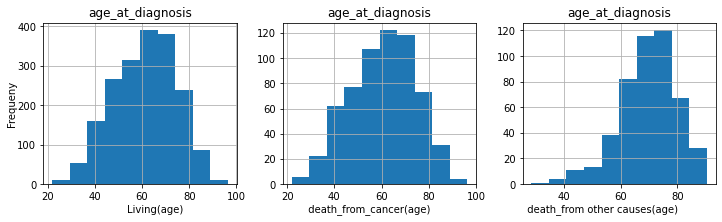

In [32]:
livingDf = originaldataDf[originaldataDf['death_from_cancer'] == 'Living']
diedDiseaseDf = originaldataDf[originaldataDf['death_from_cancer'] == 'Died of Disease']
diedOtherDf = originaldataDf[originaldataDf['death_from_cancer'] == 'Died of Other Causes']

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1, 3, 1)
originaldataDf.hist(column='age_at_diagnosis', ax = ax1)
ax2 = fig.add_subplot(1, 3, 2)
diedDiseaseDf.hist(column='age_at_diagnosis', ax = ax2)
ax3 = fig.add_subplot(1, 3, 3)
diedOtherDf.hist(column='age_at_diagnosis', ax = ax3)
fig.text(0.55, 0.0001, 'Living(age)                                        death_from_cancer(age)                               death_from other causes(age)', ha='center')
fig.text(0.001, 0.5, 'Frequeny', va='center', rotation='vertical')
fig.tight_layout()

#### NCoA3 upregulation in breast cancer‑associated ...
by MC Lira · 2023 · Cited by 1 — NCoA3 levels have been shown to be decreased during adipogenesis; however, its role in tumor‑surrounding adipose tissue (AT) remains unknown.
#### In google scholar
About 3,590 results (0.08 sec)